In [3]:
import mido
import os
import numpy as np
from scipy import stats
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow.contrib import rnn
import time

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (12, 8)

In [4]:
TICKS_PER_BEAT = 480
TEMPO = int(mido.bpm2tempo(120))

In [5]:
%run get_training_data.py

### Create training data

In [6]:
N_VALIDATION_SET = 100

In [7]:
vocab_size = 2*NUM_TRACKS*NUM_MIDI_PITCHES + NUM_TIMESHIFTS
vocab_size

772

In [154]:
# Set num training examples here. Note: actual number will be less, since some have errors
training_data, training_data_labels = get_training_vectors_from_file('TRAINING_DATA_6000.txt')

In [155]:
validation_data = training_data[:N_VALIDATION_SET]
validation_data_labels = training_data_labels[:N_VALIDATION_SET]
training_data = training_data[N_VALIDATION_SET:]
training_data_labels = training_data_labels[N_VALIDATION_SET:]

In [156]:
print("Number of training examples:", len(training_data))
training_data_labels[:7]

Number of training examples: 5644


['bomb2stg1.mid',
 'TNTNUNN.mid',
 'GQOverworld.mid',
 'RR_Music3.mid',
 'yc_1p_music_b.mid',
 'tmnt2stg1.mid',
 'Sm1cave.mid']

In [157]:
training_data[0].shape

(3910,)

#### Transpose data to create more data

In [158]:
def transpose_midi(training_example, transpose):
    notes_transpose = training_example + transpose
    outofbounds_mask = (notes_transpose%NUM_MIDI_PITCHES-transpose < 0) | (notes_transpose%NUM_MIDI_PITCHES-transpose >= 128) # find notes were transposed to different tracks
    notes_transpose -= 12*np.sign(transpose) * outofbounds_mask
    time_mask = training_example >= 2*NUM_TRACKS*NUM_MIDI_PITCHES
    notes_transpose = (1-time_mask)*notes_transpose + time_mask*training_example # so we don't transpose time duration 1-hot vectors
    return notes_transpose

In [159]:
transposed_training_data = []
transpose_keys = [-4, -3, -2, -1, 1, 2, 3, 4]
for transpose in transpose_keys: # transpose up and down up to a major third
    for data in training_data:
        transposed_training_data.append(transpose_midi(data, transpose))
training_data = np.array(list(training_data) + transposed_training_data)

In [160]:
print("Number of training examples:", len(training_data))

Number of training examples: 50796


### Parameters

In [15]:
'''# Parameters
batch_size = 10
learning_rate = 0.001
training_iters = 50000
n_input = 64
display_step = 200

# number of units in RNN cell
n_hidden = 512
n_layers = 2
'''

# Parameters
batch_size = 10
learning_rate = 0.003
training_iters = 50000
n_input = 80
display_step = 100
validation_step = 10 # every <validation_step> steps, we calculate validation error

# number of units in RNN cell
n_hidden = 350
n_layers = 2

### Create tensor flow graph

In [16]:
# tf Graph input
x = tf.placeholder("float", [batch_size, n_input, vocab_size])
y = tf.placeholder("int32", [batch_size, n_input])

# RNN output node weights and biases
softmax_w = tf.Variable(tf.random_normal([n_hidden, vocab_size]))
softmax_b = tf.Variable(tf.random_normal([vocab_size]))

max_grad_norm = 5

In [17]:
# tf Graph validation input
x_validation = tf.placeholder("float", [N_VALIDATION_SET, n_input, vocab_size])
y_validation = tf.placeholder("int32", [N_VALIDATION_SET, n_input])

In [18]:
# tf Graph generative input
x_generation = tf.placeholder("float", [1, vocab_size])

In [19]:
rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(n_hidden) for _ in range(n_layers)])

In [20]:
# Training output
x_split = tf.unstack(x, n_input, 1)
outputs, states = rnn.static_rnn(rnn_cell, x_split, dtype=tf.float32)
logits = [tf.nn.xw_plus_b(output, softmax_w, softmax_b) for output in outputs]
logits = tf.reshape(tf.split(tf.reshape(logits, [n_input, batch_size, vocab_size]), batch_size, 1), 
                    [batch_size, n_input, vocab_size])

In [21]:
# Training loss
loss = tf.contrib.seq2seq.sequence_loss(logits, y, weights=tf.ones([batch_size, n_input], dtype=tf.float32), # check this
                                        average_across_timesteps=True, average_across_batch=True)
cost = tf.reduce_sum(loss)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

In [22]:
# Validation output
x_validation_split = tf.unstack(x_validation, n_input, 1)
outputs_validation, states_validation = rnn.static_rnn(rnn_cell, x_validation_split, dtype=tf.float32)
logits_validation = [tf.nn.xw_plus_b(output, softmax_w, softmax_b) for output in outputs_validation]
logits_validation = tf.reshape(tf.split(tf.reshape(logits_validation, [n_input, N_VALIDATION_SET, vocab_size]), N_VALIDATION_SET, 1), 
                               [N_VALIDATION_SET, n_input, vocab_size])

In [23]:
# Training loss
loss_validation = tf.contrib.seq2seq.sequence_loss(logits_validation, y_validation, weights=tf.ones([N_VALIDATION_SET, n_input], dtype=tf.float32), # check this
                                        average_across_timesteps=True, average_across_batch=True)
cost_validation = tf.reduce_sum(loss_validation)

### Run tensor flow session

In [24]:
session = tf.Session()

In [25]:
identity = np.eye(vocab_size)
def get_midi_xy(data, midi_file_number):
    offset = np.random.randint(0, len(data[midi_file_number]) - n_input - 1)
    midi_x = data[midi_file_number][offset:offset+n_input]
    midi_y = data[midi_file_number][1 + offset:1 + offset+n_input].reshape(1, n_input)
    try:
        identity[midi_x.astype(int)], midi_y
    except:
        print(midi_x)
    return identity[midi_x.astype(int)], midi_y

In [26]:
def get_batch(data, num_batches):
    """Generate random batches of x and y training vectors for RNN.
       
    Returns:
        Two batches of x and y vectors.
    """
    batch_x = []
    batch_y = []
    batch = np.random.choice(range(len(data)), num_batches, replace=True)
    for b in batch:
        midi_x, midi_y = get_midi_xy(data, b%len(training_data))
        batch_x.append(midi_x)
        batch_y.append(midi_y)
    batch_y = np.reshape(batch_y, [num_batches, n_input])
    return batch_x, batch_y

In [27]:
def seconds_to_minsecstr(seconds):
    minutes = seconds//60
    seconds -= 60*minutes
    if minutes < 10: minutes = "0" + str(minutes)
    if seconds < 10: seconds = "0" + str(seconds)
    return str(minutes) + ":" + str(seconds)

In [28]:
training_loss_list = []
validation_loss_list = []
time_elapsed_list = []

init = tf.global_variables_initializer()
session.run(init)
step = 0
loss_total = 0

start_time = time.time()

while step < training_iters:
    start_a = time.time()
    
    batch_x, batch_y = get_batch(training_data, batch_size)
    _, loss = session.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
    loss_total += loss
    
    if step % validation_step == 0:
        batch_x_validation, batch_y_validation = get_batch(validation_data, N_VALIDATION_SET)
        loss_validation = session.run([cost_validation], feed_dict={x_validation: batch_x_validation, y_validation: batch_y_validation})[0]
    
    training_loss_list.append(loss)
    validation_loss_list.append(loss_validation)
    time_elapsed = seconds_to_minsecstr(int(time.time()-start_time))
    time_elapsed_list.append(time_elapsed)
    
    if (step+1) % display_step == 0:
        display = "Iter=" + str(step+1) + ", Average Loss={:.6f}, Validation Loss={:.6f}, Time Elapsed={}".format(
            loss_total/display_step, loss_validation, time_elapsed)
        print(display)
        loss_total = 0
        loss_validation_total = 0
    step += 1

Iter=350, Average Loss=5.053377, Validation Loss=3.562445, Time Elapsed=06:05
Iter=700, Average Loss=3.094753, Validation Loss=2.848822, Time Elapsed=12:18
Iter=1050, Average Loss=2.669166, Validation Loss=2.703758, Time Elapsed=18:28
Iter=1400, Average Loss=2.497509, Validation Loss=2.325366, Time Elapsed=24:41
Iter=1750, Average Loss=2.385136, Validation Loss=2.379514, Time Elapsed=31:01
Iter=2100, Average Loss=2.286249, Validation Loss=2.187094, Time Elapsed=37:22
Iter=2450, Average Loss=2.228266, Validation Loss=2.116038, Time Elapsed=43:43
Iter=2800, Average Loss=2.194785, Validation Loss=2.040742, Time Elapsed=50:06
Iter=3150, Average Loss=2.130818, Validation Loss=2.099296, Time Elapsed=56:29
Iter=3500, Average Loss=2.089898, Validation Loss=2.031844, Time Elapsed=62:52
Iter=3850, Average Loss=2.085113, Validation Loss=2.068993, Time Elapsed=69:17
Iter=4200, Average Loss=2.028692, Validation Loss=1.973371, Time Elapsed=75:42
Iter=4550, Average Loss=2.029758, Validation Loss=2.00

InvalidArgumentError: Received a label value of -8 which is outside the valid range of [0, 772).  Label values: -8 376 376 376 376 769 431 54 769 438 59 769 443 61 445 47 769 431 54 769 438 59 769 443 61 445 71 47 769 431 54 769 455 438 66 59 769 443 61 771 769 450 71 768 455 73 768 457 74 768 458 76 460 445 78 45 769 429 52 769 436 59 769 443 61 771 768 462 78 768 462 78 768 462 79 769 463 81 465 445 768 446 57 769 441 57 768 181 768 441 72 768 565 768 456 62 768 176 768 446 57 560 768 179 768 441 57 563 768 180 768 441 72 564 768 181 768 456 62 768 565 768 446 57 769 441 57 768 181 768 441 72 768 565 768 456 62 768 176 768 446 57 560 768 179 768 441 57 563 768 180 768 441 72 564 768 181 768 456 62 691 307 768 566 691 768 479 182 307 768 566 182 691 307 768 90 566 183 691 306 768 567 690 768 183 306 768 474 95 567 183 690 306 768 479 62 567 183 690 306 768 446 67 567 690 768 451 69 183 306 768 453 71 567 183 690 306 768 455 567 183 690 306 768 567 690 768 183 306 768 567 183 690 306 768 567 183 690 306 768 768 579 199 680 287 768 583 768 202 671 299 768 586 768 463 475 90 78 683 286 768 201 768 585 670 298 769 682 285 768 197 768 581 669 297 769 462 474 91 79 681 284 768 204 768 668 296 768 588 768 680 284 769 668 296 768 202 768 463 475 93 81 586 200 680 282 768 584 207 768 591 666 294 769 465 477 95 83 678 283 768 670 298 768 682 305 768 689 310 768 694 298 768 682 298 768 682 298 768 682 298 768 682 298 769 682 286 768 670 298 768 682 305 768 689 298 768 682 297 769 681 285 768 669 297 768 681 304 768 688 309 768 693 297 768 681 297 768 681 309 768 693 309 768 693 297 769 681 285 768 669 297 768 681 304 768 688 297 768 681 188 768 448 65 572 190 306 768 690 769 449 67 574 192 768 451 576 303 768 687 770 57 181 297 768 441 565 681 769 60 184 768 444 60 568 184 301 768 685 769 444 57 568 181 768 441 63 565 185 304 768 447 569 688 769 62 185 768 446 569 301 768 685 770 60 183 292 768 444 567 676 770 296 768 680 770 299 768 683 770 471 80 689 768 464 83 768 467 85 580 192 313 768 469 697 313 768 85 697 768 469 78 768 462 83 768 467 78 768 462 80 313 768 464 76 697 313 768 460 73 697 768 457 768 85 768 469 88 768 472 80 576 194 768 464 87 768 471 80 768 464 83 768 467 85 578 191 312 768 469 696 312 768 85 696 768 469 78 768 462 682 298 769 682 298 769 682 298 769 682 298 769 682 298 769 682 298 769 682 298 769 682 298 769 682 297 769 70 194 681 295 769 679 295 769 679 295 768 578 768 454 66 191 679 295 769 679 295 769 679 295 768 575 768 450 69 193 679 295 769 453 70 577 194 679 295 769 454 69 578 193 679 297 769 681 297 768 577 768 453 768 545 289 768 160 673 768 544 288 768 159 672 768 543 287 768 160 671 768 544 153 288 768 537 153 672 281 768 537 153 665 281 768 537 153 665 281 768 537 153 665 281 768 537 665 281 768 665 770 161 768 545 289 768 160 673 768 544 288 768 159 672 768 543 287 768 160 671 768 61 64 544 153 288 768 537 153 672 281 768 578 199 202 187 190 195 680 287 768 467 768 86 671 294 768 470 678 768 83 287 769 671 294 768 678 768 467 90 287 769 671 294 768 678 768 474 83 287 769 671 294 769 467 93 579 571 583 586 574 199 201 187 189 194 678 286 769 670 293 768 677 768 286 769 670 293 768 677 768 477 90 578 571 583 585 573 186 198 189 194
	 [[Node: sequence_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](sequence_loss/Reshape, sequence_loss/Reshape_1)]]

Caused by op 'sequence_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits', defined at:
  File "C:\Users\johnm\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\johnm\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\johnm\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\johnm\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\johnm\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\johnm\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\johnm\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\johnm\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-3b4900b20d68>", line 3, in <module>
    average_across_timesteps=True, average_across_batch=True)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\tensorflow\contrib\seq2seq\python\ops\loss.py", line 92, in sequence_loss
    labels=targets, logits=logits_flat)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1879, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 4546, in _sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\johnm\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Received a label value of -8 which is outside the valid range of [0, 772).  Label values: -8 376 376 376 376 769 431 54 769 438 59 769 443 61 445 47 769 431 54 769 438 59 769 443 61 445 71 47 769 431 54 769 455 438 66 59 769 443 61 771 769 450 71 768 455 73 768 457 74 768 458 76 460 445 78 45 769 429 52 769 436 59 769 443 61 771 768 462 78 768 462 78 768 462 79 769 463 81 465 445 768 446 57 769 441 57 768 181 768 441 72 768 565 768 456 62 768 176 768 446 57 560 768 179 768 441 57 563 768 180 768 441 72 564 768 181 768 456 62 768 565 768 446 57 769 441 57 768 181 768 441 72 768 565 768 456 62 768 176 768 446 57 560 768 179 768 441 57 563 768 180 768 441 72 564 768 181 768 456 62 691 307 768 566 691 768 479 182 307 768 566 182 691 307 768 90 566 183 691 306 768 567 690 768 183 306 768 474 95 567 183 690 306 768 479 62 567 183 690 306 768 446 67 567 690 768 451 69 183 306 768 453 71 567 183 690 306 768 455 567 183 690 306 768 567 690 768 183 306 768 567 183 690 306 768 567 183 690 306 768 768 579 199 680 287 768 583 768 202 671 299 768 586 768 463 475 90 78 683 286 768 201 768 585 670 298 769 682 285 768 197 768 581 669 297 769 462 474 91 79 681 284 768 204 768 668 296 768 588 768 680 284 769 668 296 768 202 768 463 475 93 81 586 200 680 282 768 584 207 768 591 666 294 769 465 477 95 83 678 283 768 670 298 768 682 305 768 689 310 768 694 298 768 682 298 768 682 298 768 682 298 768 682 298 769 682 286 768 670 298 768 682 305 768 689 298 768 682 297 769 681 285 768 669 297 768 681 304 768 688 309 768 693 297 768 681 297 768 681 309 768 693 309 768 693 297 769 681 285 768 669 297 768 681 304 768 688 297 768 681 188 768 448 65 572 190 306 768 690 769 449 67 574 192 768 451 576 303 768 687 770 57 181 297 768 441 565 681 769 60 184 768 444 60 568 184 301 768 685 769 444 57 568 181 768 441 63 565 185 304 768 447 569 688 769 62 185 768 446 569 301 768 685 770 60 183 292 768 444 567 676 770 296 768 680 770 299 768 683 770 471 80 689 768 464 83 768 467 85 580 192 313 768 469 697 313 768 85 697 768 469 78 768 462 83 768 467 78 768 462 80 313 768 464 76 697 313 768 460 73 697 768 457 768 85 768 469 88 768 472 80 576 194 768 464 87 768 471 80 768 464 83 768 467 85 578 191 312 768 469 696 312 768 85 696 768 469 78 768 462 682 298 769 682 298 769 682 298 769 682 298 769 682 298 769 682 298 769 682 298 769 682 298 769 682 297 769 70 194 681 295 769 679 295 769 679 295 768 578 768 454 66 191 679 295 769 679 295 769 679 295 768 575 768 450 69 193 679 295 769 453 70 577 194 679 295 769 454 69 578 193 679 297 769 681 297 768 577 768 453 768 545 289 768 160 673 768 544 288 768 159 672 768 543 287 768 160 671 768 544 153 288 768 537 153 672 281 768 537 153 665 281 768 537 153 665 281 768 537 153 665 281 768 537 665 281 768 665 770 161 768 545 289 768 160 673 768 544 288 768 159 672 768 543 287 768 160 671 768 61 64 544 153 288 768 537 153 672 281 768 578 199 202 187 190 195 680 287 768 467 768 86 671 294 768 470 678 768 83 287 769 671 294 768 678 768 467 90 287 769 671 294 768 678 768 474 83 287 769 671 294 769 467 93 579 571 583 586 574 199 201 187 189 194 678 286 769 670 293 768 677 768 286 769 670 293 768 677 768 477 90 578 571 583 585 573 186 198 189 194
	 [[Node: sequence_loss/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](sequence_loss/Reshape, sequence_loss/Reshape_1)]]


### Plots

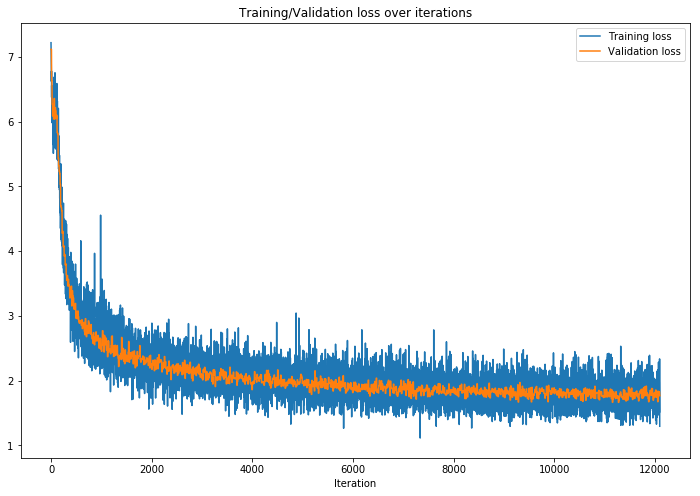

In [40]:
plt.plot(training_loss_list, label='Training loss')
plt.plot(validation_loss_list, label='Validation loss')
plt.xlabel('Iteration')
plt.title('Training/Validation loss over iterations')
plt.legend()
plt.show()

### Create log file

In [41]:
logfile_directory = 'logs/'

In [42]:
validation_loss_list = np.array(validation_loss_list)
min_valid_loss = np.inf
min_valid_loss_iteration = -1
for i in range(validation_step*10, len(validation_loss_list)-validation_step*10)[::validation_step]:
    valid_loss_mean = np.nanmean(validation_loss_list[i-validation_step*10:i+validation_step*10]) # smoothed validation mean
    if valid_loss_mean < min_valid_loss:
        min_valid_loss = valid_loss_mean
        min_valid_loss_iteration = i
        
train_loss_mean = np.nanmean(np.array(np.array(training_loss_list)[-50:]))
valid_loss_mean = np.nanmean(np.array(np.array(validation_loss_list)[-50:]))
train_loss_mean, valid_loss_mean

min_valid_loss, min_valid_loss_iteration, train_loss_mean, valid_loss_mean

(1.7545917, 11330, 1.7943364, 1.7899835)

In [43]:
date = time.strftime("%Y-%m-%d %H.%M")
logfile_name ="Logfile (Date={}, MinValidLoss={:.2f}, TrainLoss={:.2f}, Iterations={}).txt". \
    format(date, min_valid_loss, train_loss_mean, len(validation_loss_list))
logfile_name

'Logfile (Date=2017-11-21 12.52, MinValidLoss=1.75, TrainLoss=1.79, Iterations=12094).txt'

In [44]:
logfile = open(logfile_directory + logfile_name, "w")

logfile.write("Training loss={:.6f}\n".format(train_loss_mean))
logfile.write("Validation loss={:.6f}\n".format(valid_loss_mean))
logfile.write("Min Validation loss={:.6f}\n".format(min_valid_loss))
logfile.write("Iteration of min validation loss={}\n\n".format(min_valid_loss_iteration))

logfile.write("Iterations trained={}\n".format(len(time_elapsed_list)))
logfile.write("Duration={}\n\n".format(time_elapsed_list[-1]))

logfile.write("Number of training examples={}\n".format(len(training_data)))
logfile.write("Number of validation examples={}\n\n".format(len(validation_data)))


logfile.write("Batch size={}\n".format(batch_size))
logfile.write("Learning rate={:.6f}\n".format(learning_rate))
logfile.write("Number of input (T)={}\n\n".format(n_input))

logfile.write("Number of hidden layers={}\n".format(n_layers))
logfile.write("Number of hidden units per year={}\n\n".format(n_hidden))

for i in range(len(training_loss_list)):
    logfile.write("Iter={}, Training Loss={:.6f}, Validation Loss={:.6f}, Time Elapsed={}\n".format(
            (i+1), training_loss_list[i], validation_loss_list[i], time_elapsed_list[i]))
    
logfile.close()

### Generate music from trained model

In [102]:
N_GENERATED_NOTE_VECTORS = 1000
N_STARTING_NOTES = 10
temperature = 0.8

In [103]:
state_placeholder = tf.placeholder(tf.float32, [n_layers, 2, 1, n_hidden])
l = tf.unstack(state_placeholder, 2, 0)
rnn_tuple_state = tuple([tf.nn.rnn_cell.LSTMStateTuple(l[i][0], l[i][1]) for i in range(n_layers)])

outputs_generation, states_generation = rnn.static_rnn(rnn_cell, [x_generation], 
                                                       initial_state=rnn_tuple_state, dtype=tf.float32)

logits_generation = tf.nn.xw_plus_b(outputs_generation[0], softmax_w, softmax_b)

In [104]:
seed_notes = []
training_data_index = int(len(training_data)*np.random.random())
for i in range(N_STARTING_NOTES):
    seed_note = np.eye(vocab_size)[training_data[training_data_index][i]]
    seed_note = np.reshape(seed_note, [1, vocab_size])
    seed_notes.append(seed_note)
print(training_data_labels[training_data_index%5644])

PkmGS-38.mid


Previous note: [ 562.]
Posterior probability: [  1.39318274e-07   8.01447698e-07   2.27163454e-07   1.03209447e-06]


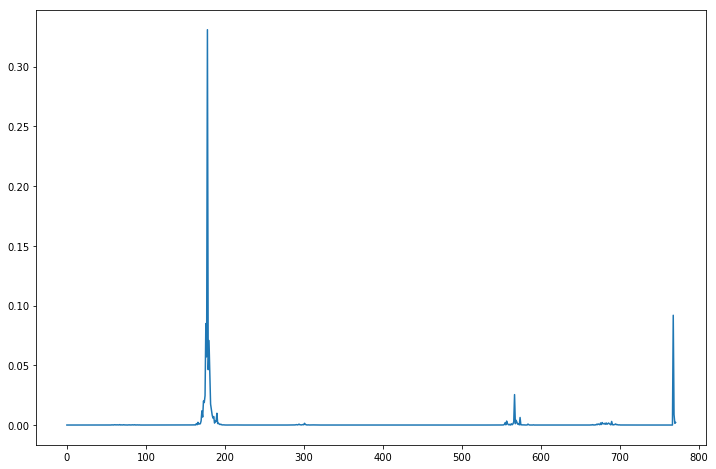

Previous note: [ 178.]
Posterior probability: [  5.11481524e-08   2.25674395e-08   9.86948834e-08   4.13783177e-08]


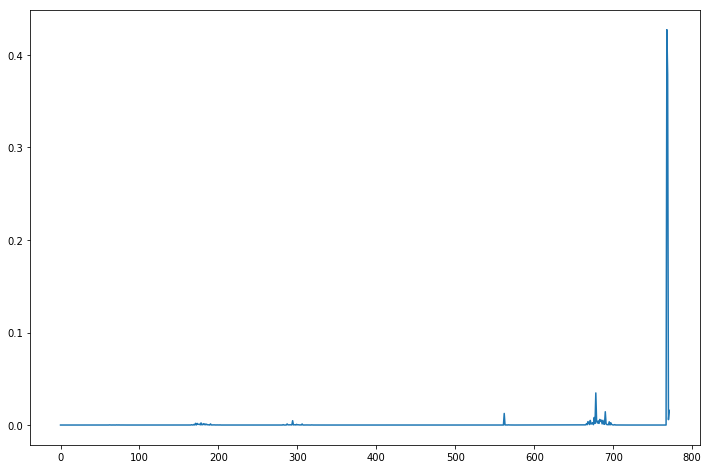

Previous note: [ 769.]
Posterior probability: [  1.38254350e-08   7.33160510e-09   4.05647071e-08   4.39423360e-08]


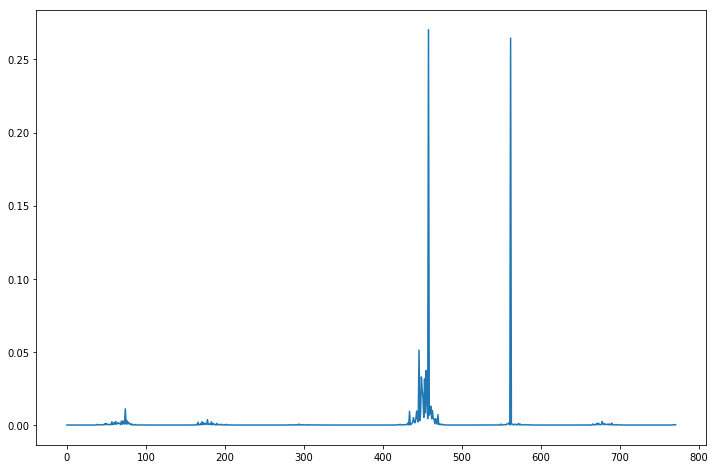

Previous note: [ 562.]
Posterior probability: [  1.58673856e-08   1.81580759e-08   5.05055731e-08   2.37790175e-07]


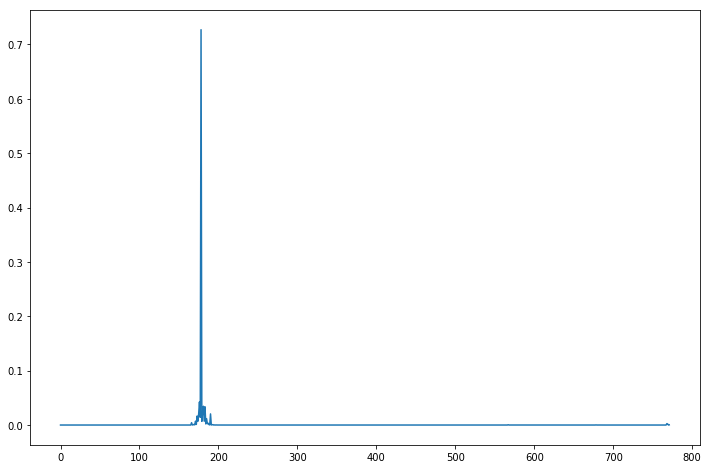

In [105]:
generated_music = seed_notes
saved_state = np.zeros((n_layers, 2, 1, n_hidden))
for i in range(N_GENERATED_NOTE_VECTORS):
    onehot_pred, new_state = session.run([logits_generation, states_generation], 
                                         feed_dict={x_generation: generated_music[-1], state_placeholder: saved_state})
    saved_state = new_state
    next_note = np.zeros(vocab_size)
    #index = np.argmax(onehot_pred, 1) # take max probability
    softmax_cdf = np.exp(onehot_pred[0]/temperature)/np.sum(np.exp(onehot_pred[0]/temperature))
    
    if i < 4:
        print("Previous note:", generated_music[-1].dot(range(vocab_size)))
        print("Posterior probability:", softmax_cdf[:4])
        plt.plot(softmax_cdf)
        plt.show()
        
    index = np.random.choice(range(vocab_size), p=softmax_cdf) # choose probabilistically
    
    next_note[index] = 1
    next_note = np.reshape(next_note, [1, vocab_size])
    
    generated_music.append(next_note)

In [106]:
notes = np.array(generated_music).reshape(N_GENERATED_NOTE_VECTORS+N_STARTING_NOTES, vocab_size).dot(np.array(range(vocab_size)))
notes

array([  55.,  178.,  294., ...,  559.,  175.,  768.])

### Convert generated music to midi

In [107]:
def get_track_sequences(vector_sequence):
    """Get note sequences for each track from vector sequence output from RNN.

    Args:
       vector_sequence: List of one-hot vectors containing 128 * NUM_TRACKS note_on events, 128 * NUM_TRACKS note_off events,
        and NUM_TIMESHIFTS timeshift events in intervals of 1/96 of a beat each.
       
    Returns:
        List of track vector sequences.
    """
    track_sequences = [[] for _ in range(NUM_TRACKS)]
    start_time = 0
    for vector in vector_sequence:
        index = vector.index(1)
        # vector is a time event.
        if index >= NUM_MIDI_PITCHES * 2 * NUM_TRACKS:
            num_beats = (index - NUM_MIDI_PITCHES * 2 * NUM_TRACKS + 1) / NUM_TIMESHIFTS
            start_time += num_beats
        else:
            # vector is a note_off event.
            if index >= NUM_MIDI_PITCHES * NUM_TRACKS:
                note_type = 'note_off'
                index -= NUM_MIDI_PITCHES * NUM_TRACKS
            # vector is a note_on event.
            else:
                note_type = 'note_on'
            track_num = int(index / NUM_MIDI_PITCHES)
            note = index % NUM_MIDI_PITCHES
            track_sequences[track_num].append({"type": note_type, "note": note, "start_time": start_time})
            time_delay = 0
            
    return track_sequences
    

In [108]:
def get_midi_from_vector_sequence(track_sequences):
    """Get midi from track sequences.

    Args:
       track_sequences: List of vector sequences for each track.
       
    Returns:
        MidiFile object.
    """
    mid = mido.MidiFile()
    tracks = [mido.MidiTrack() for _ in range(NUM_TRACKS)]
    mid.tracks.extend(tracks)

    for i, ts in enumerate(track_sequences):
        prev_start_time = 0
        for event in ts:
            time = event["start_time"] - prev_start_time
            prev_start_time = event["start_time"]
            # I picked a random number for velocity.
            mid.tracks[i].append(mido.Message(event["type"], note=event["note"], velocity=50,
                                              time=int(time * TICKS_PER_BEAT)))
    
    return mid

In [109]:
track_sequence = get_track_sequences([list(x[0]) for x in generated_music])

In [110]:
track_sequence[1]

[{'note': 50, 'start_time': 0, 'type': 'note_on'},
 {'note': 50, 'start_time': 0.5, 'type': 'note_off'},
 {'note': 50, 'start_time': 0.5, 'type': 'note_on'},
 {'note': 50, 'start_time': 1.0, 'type': 'note_off'},
 {'note': 50, 'start_time': 1.0, 'type': 'note_on'},
 {'note': 50, 'start_time': 1.5, 'type': 'note_off'},
 {'note': 50, 'start_time': 1.5, 'type': 'note_on'},
 {'note': 50, 'start_time': 2.0, 'type': 'note_off'},
 {'note': 50, 'start_time': 2.0, 'type': 'note_on'},
 {'note': 50, 'start_time': 2.5, 'type': 'note_off'},
 {'note': 50, 'start_time': 2.5, 'type': 'note_on'},
 {'note': 50, 'start_time': 3.0, 'type': 'note_off'},
 {'note': 50, 'start_time': 3.0, 'type': 'note_on'},
 {'note': 50, 'start_time': 3.5, 'type': 'note_off'},
 {'note': 50, 'start_time': 3.5, 'type': 'note_on'},
 {'note': 50, 'start_time': 4.0, 'type': 'note_off'},
 {'note': 45, 'start_time': 4.0, 'type': 'note_on'},
 {'note': 45, 'start_time': 4.5, 'type': 'note_off'},
 {'note': 50, 'start_time': 4.5, 'type'

In [111]:
midi = get_midi_from_vector_sequence(track_sequence)
midi

<midi file None type 1, 3 tracks, 676 messages>

# Save midi

In [112]:
generation_output = "generated_music/"

In [113]:
midi_name = "Generated Music (Date={}, Temperature={}, Length={}, MinValidLoss={:.2f}, TrainLoss={:.2f}, Iterations={}).mid". \
    format(date, temperature, N_GENERATED_NOTE_VECTORS, min_valid_loss, train_loss_mean, len(validation_loss_list))
midi_name

'Generated Music (Date=2017-11-21 12.52, Temperature=0.8, Length=1000, MinValidLoss=1.75, TrainLoss=1.79, Iterations=12094).mid'

In [114]:
midi.save(generation_output + midi_name)